## IS6 in Python: Confidence Intervals for means (Chapter 14)

### Introduction and background

This document is intended to assist students in undertaking examples shown in the Sixth Edition of Intro Stats (2022) by De Veaux, Velleman, and Bock. This pdf file as well as the associated ipynb reproducible analysis source file used to create it can be found at (INSERT WEBSITE LINK HERE).

#### Chapter 14: Confidence Intervals for Means

In [2]:
#Load in libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.api import qqplot
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

In [3]:
baby = pd.read_csv("datasets/babysamp-98.txt", sep = "\t")
baby

,MomAge,DadAge,MomEduc,MomMarital,numlive,dobmm,gestation,sex,weight,prenatalstart,orig.id,preemie
0,35,35.0,17.0,1,2,2,39,F,3175,1.0,1047483,False
1,22,21.0,12.0,1,1,3,42,F,3884,2.0,1468100,False
2,35,42.0,15.0,1,0,6,39,F,3030,2.0,2260016,False
3,23,NaN,6.0,1,2,8,40,F,3629,1.0,3583052,False
4,23,28.0,13.0,1,0,9,42,F,3481,2.0,795674,False
...,...,...,...,...,...,...,...,...,...,...,...,...
195,25,NaN,12.0,2,2,5,40,F,2858,2.0,2329810,False
196,34,35.0,11.0,1,1,6,40,M,2530,2.0,435373,False
197,36,37.0,16.0,1,0,2,37,M,3204,1.0,3315797,False
198,23,26.0,11.0,1,1,8,39,M,3572,2.0,1254365,False


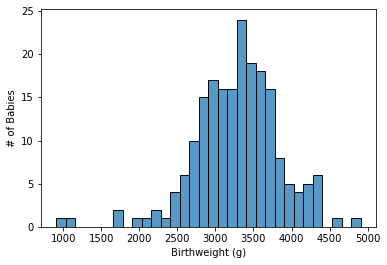

In [4]:
sns.histplot(data = baby, x = "weight", binwidth = 125)
plt.xlabel("Birthweight (g)")
plt.ylabel("# of Babies")
plt.show()

In [5]:
#Mean of a random sample of 100
print(baby.sample(100, random_state = 1)["weight"].mean())

3216.51


In [6]:
#Mean of another random sample of 100
print(baby.sample(100, random_state = 13)["weight"].mean())

3290.67


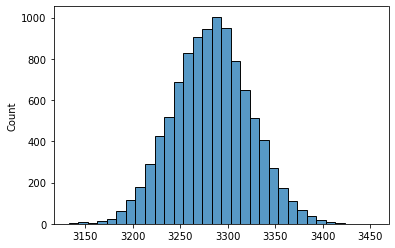

In [7]:
#Sample 10000 times
means = np.zeros(10000)
for i in range(10000):
    means[i] = baby.sample(100, random_state = i)["weight"].mean()
    
#Plot
sns.histplot(data = means, binwidth = 10)
plt.show()

In [8]:
means = pd.DataFrame(means)
print(means.describe())

                  0
count  10000.000000
mean    3282.675136
std       40.412948
min     3132.960000
25%     3255.070000
50%     3282.850000
75%     3309.795000
max     3451.460000


#### Section 14.1: The Central Limit Theorem

In [9]:
ceo = pd.read_csv("datasets/ceo-compensation-2018.txt", sep = "\t")
ceo.head()

,TIcker,Company,CEO,Compensation,Compensation (M),Median Worker Pay,Ratio
0,DISCA,"Discovery, Inc.",David Zaslav,129499005,129.499010,85704.0,1511.0
1,TMUS,"T-Mobile US, Inc.",John Legere,66538206,66.538206,59653.0,1115.0
2,LIN,Linde Plc,Stephen Angel,66149325,66.149325,40601.0,1629.0
3,DIS,The Walt Disney Co.,Robert Iger,65645214,65.645214,46127.0,1423.0
4,CBS,CBS Corporation,Leslie Moonves,47061688,47.061688,NaN,NaN


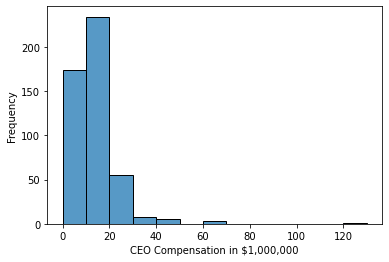

In [10]:
#Figure 14.3, page 466
sns.histplot(data = ceo, x = "Compensation (M)", binwidth = 10)
plt.xlabel("CEO Compensation in $1,000,000")
plt.ylabel("Frequency")
plt.show()

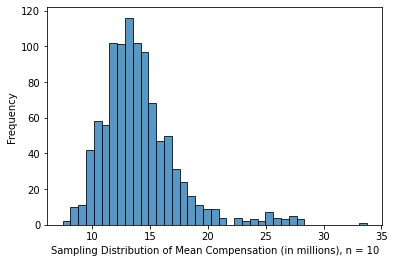

In [11]:
#Figure 14.4, page 466
#Sample 1000 times
means10 = np.zeros(1000)
for i in range(1000):
    means10[i] = ceo.sample(10, random_state = i)["Compensation (M)"].mean()
    
#Plot
sns.histplot(data = means10)
plt.xlabel("Sampling Distribution of Mean Compensation (in millions), n = 10")
plt.ylabel("Frequency")
plt.show()

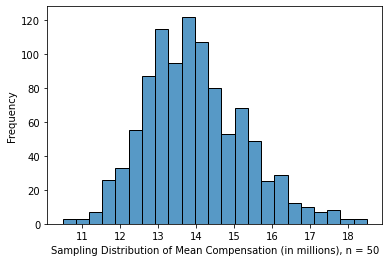

In [12]:
#Figure 14.5
#Sample 1000 times
means50 = np.zeros(1000)
for i in range(1000):
    means50[i] = ceo.sample(50, random_state = i)["Compensation (M)"].mean()
    
#Plot
sns.histplot(data = means50)
plt.xlabel("Sampling Distribution of Mean Compensation (in millions), n = 50")
plt.ylabel("Frequency")
plt.show()

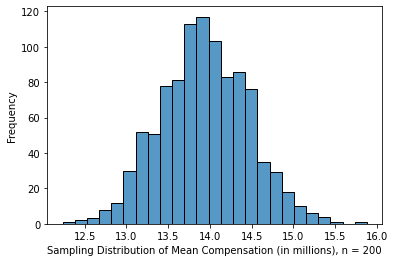

In [13]:
#figure 14.7
#Sample 1000 times
means200 = np.zeros(1000)
for i in range(1000):
    means200[i] = ceo.sample(200, random_state = i)["Compensation (M)"].mean()
    
#Plot
sns.histplot(data = means200)
plt.xlabel("Sampling Distribution of Mean Compensation (in millions), n = 200")
plt.ylabel("Frequency")
plt.show()

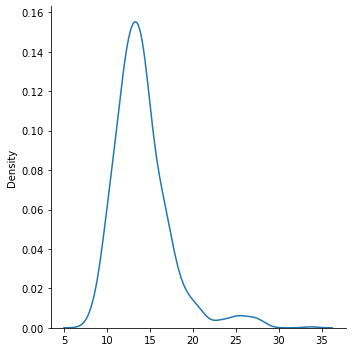

In [14]:
sns.displot(data = means10, kind = "kde")
plt.show()

In [15]:
#Wrangle data
means10 = pd.DataFrame(means10, columns = ["means10"])
means50 = pd.DataFrame(means50, columns = ["means50"])
means200 = pd.DataFrame(means200, columns = ["means200"])

data = pd.concat([means10, means50, means200], axis = 1)
data.head()

,means10,means50,means200
0,16.548741,14.105569,14.197191
1,13.410214,13.649756,13.287595
2,10.350133,12.641901,13.891747
3,14.505094,13.559351,13.971897
4,16.757225,14.262437,13.589530


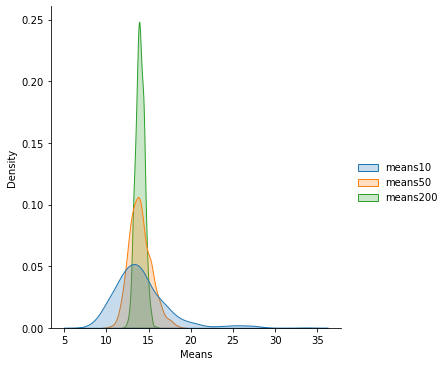

In [17]:
#Plot
sns.displot(data = data, kind = "kde", fill = True)
plt.xlabel("Means")
plt.ylabel("Density")
plt.show()

#### Section 14.2: A Confidence Interval for the Mean
#### Example 14.1: A One-Sample t-interval for the Mean

In [24]:
#Page 471
salmon = pd.read_csv("datasets/farmed-salmon.txt", sep = "\t")
salmon = salmon[salmon["Mirex"] != "NA"]
df_stats = salmon["Mirex"].describe()
print(df_stats)

count    150.000000
mean       0.091340
std        0.049524
min        0.000000
25%        0.056000
50%        0.079000
75%        0.134750
max        0.194000
Name: Mirex, dtype: float64
